In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


In [7]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import numpy as np
import itertools
import pandas as pd
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
import neptune.new as neptune
from datetime import datetime

from Utils.add_features import add_fisher
from Data.data_retrieval import get_data
from Utils.neptune_ai_api_key import API_KEY

np.random.seed(12)

In [8]:



def create_state_df(df, price_states_value, fisher_states_value, UseFisherinStateSpace):
    df['Normalized_Close_state'] = df['Normalized_Close'].apply(lambda x : value_to_state(x, price_states_value))
    fisher_cols = []
    for column in df.columns:
        if column.startswith('Normalized_Fisher'):
            fisher_cols.append(column)
    for i in range(len(fisher_cols)):
        df[f'{fisher_cols[i]}_state'] = df[fisher_cols[i]].apply(lambda x: value_to_state(x, fisher_states_value[i]))
    df['Fisher_state'] = df[[f'{col}_state' for col in fisher_cols]].agg(''.join, axis=1)
    if UseFisherinStateSpace:
        df['state'] = df['Normalized_Close_state'] + df['Fisher_state']
    else:
        df['state'] = df['Normalized_Close_state']
    df.dropna(inplace=True)
    return df

def get_all_states(price_states_value,  fisher_states_value, state_lookback, UseFisherinStateSpace):
    states = []
    if not(UseFisherinStateSpace):
        fisher_states_value = []
    for p, _ in price_states_value.items():
        fisher_states = []
        for i in range(len(fisher_states_value)):
            fisher_states.append(list(fisher_states_value[i].items()))
        fisher_states = list(itertools.product(*fisher_states))
        for fs in fisher_states:
            fisher_state = ''
            for f in fs:
                c, _ = f
                fisher_state =  fisher_state + str(c)
            states.append(str(p)+fisher_state)
    states = list(itertools.product(*[states for i in range(state_lookback)]))
    states = [''.join(state) for state in states]
    return states

def initialize_q_mat(all_states, all_actions):
    states_size = len(all_states)
    actions_size = len(all_actions)
    q_mat = np.random.rand(states_size, actions_size) / 1e9
    q_mat = pd.DataFrame(q_mat, columns=all_actions.keys())
    q_mat['states'] = all_states
    q_mat.set_index('states', inplace=True)
    return q_mat

def get_return_since_entry(bought_history, current_adj_close):
    return_since_entry = 0.
    for b in bought_history:
        return_since_entry += (current_adj_close - b)
    return return_since_entry

def visualize_results(actions_history, returns_since_entry):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    ax1.plot(returns_since_entry,  linewidth=0.2)

    days, prices, actions = [], [], []
    for d, p, a in actions_history:
        days.append(d)
        prices.append(p)
        actions.append(a)

    # ax2.figure(figsize=(20,10))
    ax2.plot(days, prices, label='normalized adj close price',  linewidth=0.2)
    hold_d, hold_p, buy_d, buy_p, sell_d, sell_p = [], [], [], [], [], []
    for d, p, a in actions_history:
        if a == 0:
            hold_d.append(d)
            hold_p.append(p)
        if a == 1:
            buy_d.append(d)
            buy_p.append(p)
        if a == 2:
            sell_d.append(d)
            sell_p.append(p)
        # ax2.annotate(all_actions[a], xy=(d,p), xytext=(d-.2, p+0.001), color=color, arrowprops=dict(arrowstyle='->',connectionstyle='arc3'))
    # ax2.scatter(hold_d, hold_p, color='blue', label='hold', s=2)
    ax2.scatter(buy_d, buy_p, color='green', label='buy', s=10)
    ax2.scatter(sell_d, sell_p, color='red', label='sell', s=10)
    ax2.legend()
    return f

def get_invested_capital(actions_history, returns_since_entry):
    invest = []
    total = 0
    return_invest_ratio = None
    for i in range(len(actions_history)):
        a = actions_history[i][2]
        p = actions_history[i][1]
        try:
            next_a = actions_history[i + 1][2]
        except:
            break
        if a == 1:
            total += p
            if next_a != 1 or (i == len(actions_history) - 2 and next_a == 1):
                invest.append(total)
                total = 0
    if invest:
        return_invest_ratio = returns_since_entry[-1] / max(invest)
        print('invested capital {}, return/invest ratio {}'.format(max(invest), return_invest_ratio))
    else:
        print('no buy transactions, invalid training')
    return return_invest_ratio

def get_base_return(data):
    start_price, _ = data[0]
    end_price, _ = data[-1]
    return (end_price - start_price) / start_price

def get_sell_reward(returns, theta, type="absolute"):
    if type=="percent":
        for i, ret in enumerate(returns):
            if i == 0:
                returns[i] = 0
            if ret<0:
                returns[i] = theta*ret
        tot_ret = 1
        for ret in returns:
            tot_ret = tot_ret*(1+ret)
        tot_ret = tot_ret-1
        return tot_ret

    if type=="absolute":
        for i, ret in enumerate(returns):
            if i==0:
                returns[i] = 0
            if ret<0:
                returns[i] = theta*ret
        tot_ret = sum(returns)
        return tot_ret

def act(state, q_mat, threshold=0.2, actions_size=3):
    if np.random.uniform(0, 1) < threshold:
        action_priority = np.arange(0,actions_size)
        np.random.shuffle(action_priority)
    else:
        action_priority = q_mat.loc[state].values.argsort()[-actions_size:][::-1]
    return action_priority

def act_nn(state, model, num_states, threshold=0.2, actions_size=3):
    if np.random.uniform(0, 1) < threshold:
        action_priority = np.arange(0, actions_size)
        np.random.shuffle(action_priority)
    else:
        action_priority =model.predict(np.identity(num_states)[int(state):int(state) + 1]).argsort()[-actions_size:][::-1]
    return action_priority

def get_model(num_states, actions_size):
    model = Sequential()
    model.add(InputLayer(batch_input_shape=(1, num_states)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(actions_size, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

def train_q_learning(train, state_lookback, q, num_states, use_nn, alpha, epsilon, gamma, episodes, buy_reward, max_units=1, metric="absolute" , theta=2):
    if use_nn:
        model = get_model(num_states, actions_size=3)
    else:
        model = None
    train_df = train.copy()
    train_df["PctReturns"] = train_df["Normalized_Close"]/train_df["Normalized_Close"].shift(1)-1
    train_df["AbsReturns"] = train_df["Normalized_Close"].diff(1)
    train_df.dropna(inplace=True)
    dates = list(train_df.index)
    train_data = train_df[["Normalized_Close", "state"]]
    actions_history = []
    returns_since_entry = [0]
    train_returns = []
    equity_curve = []

    for ii in tqdm(range(episodes)):
        actions_history = []
        num_shares = 0
        bought_history = []
        bought_history_dates = []
        returns_since_entry = [0]
        equity_curve = []

        for i, val in enumerate(np.array(train_data)):
            if i<state_lookback:
                continue
            current_adj_close, state = val
            prev_adj_close, _ = np.array(train_data)[i - 1]
            fisher_state = train_df.iloc[i]["Fisher_state"]
            state = ''.join(list(train_data.iloc[i - state_lookback:i]["state"])[::-1])
            current_date = dates[i]
            try:
                equity_curve.append(equity_curve[-1]+num_shares * (current_adj_close-prev_adj_close))
            except:
                equity_curve.append(0)

            if len(bought_history) > 0:
                returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close))
            else:
                returns_since_entry.append(returns_since_entry[-1])

            # decide action
            if epsilon > 0.1:
                epsilon = epsilon / (i + 1)

            if use_nn:
                action_priority = act_nn(state, model, num_states, threshold=epsilon, actions_size=3)
            else:
                action_priority = act(state, q, threshold=epsilon, actions_size=3)

            action = action_priority[0]

            # Constraining max number of units bought
            if (num_shares >= max_units) and (action == 1):
                action = action_priority[1]

            # Short Selling not Allowed
            if (num_shares <= 0) and (action == 2):
                action = action_priority[1]

            # Forcing Trades
            # if state[:state_lookback]=='0'*state_lookback:
            #     action=1
            # elif state[:state_lookback]=='9'*state_lookback:
            #     if num_shares==0:
            #         action=0
            #     else:
            #         action=2
            # else:
            #     action=0
            #
            # # Constraining max number of units bought
            # if (num_shares >= max_units) and (action == 1):
            #     action = 0
            #
            # # Short Selling not Allowed
            # if (num_shares <= 0) and (action == 2):
            #     action = 0

            # get reward
            if action == 0:  # hold
                if num_shares > 0:
                    past = current_adj_close - prev_adj_close   #should this be multiplied by num_shares
                    if metric == "percent":
                        reward = past/prev_adj_close
                    else:
                        reward = past
                else:
                    reward = 0

            if action == 1:  # buy
                if fisher_state=='0':
                    reward = buy_reward
                else:
                    reward = 0
                num_shares += 1
                bought_history.append((current_adj_close))
                bought_history_dates.append((current_date))

            if action == 2:  # sell
                bought_date = bought_history_dates[0]
                #penalize negative moves
                if metric=="percent":
                    reward = get_sell_reward(list(train_df.loc[bought_date:current_date]["PctReturns"]), theta, type=metric)
                if metric == "absolute":
                    reward = get_sell_reward(list(train_df.loc[bought_date:current_date]["AbsReturns"]), theta, type=metric)
                bought_history.pop(0)
                bought_history_dates.pop(0)
                num_shares -= 1

            try:
                next_adj_close, next_state = np.array(train_data)[i + 1]
                next_state = ''.join(list(train_data.iloc[i - state_lookback+1:i+1]["state"])[::-1])
            except:
                break


            # print(f"Train action: {action}")
            # print(f"State: {state}")
            # print(f"Reward: {reward}")
            # print(f"Num units: {num_shares}")
            # print("*"*100)



            actions_history.append((i, current_adj_close, action))

            if use_nn:
                target = reward + gamma *np.max(model.predict(np.identity(num_states)[int(next_state):int(next_state) + 1]))
                target_vector = model.predict(np.identity(num_states)[int(state):int(state) + 1])[0]
                target_vector[action] = target
                model.fit(np.identity(num_states)[int(state):int(state) + 1], target_vector.reshape(-1, 3),epochs=1, verbose=0)
            else:
                # update q table
                q.loc[state, action] = (1. - alpha) * q.loc[state, action] + alpha * (
                            reward + gamma * (q.loc[next_state].max()))

        train_returns.append(get_invested_capital(actions_history, returns_since_entry))


    train_results_over_episodes = train_returns
    print('End of Training!')
    return q, actions_history, returns_since_entry, model, train_results_over_episodes, equity_curve


def eval_q_learning(test_data, q, max_units, state_lookback):
    actions_history = []
    num_shares = 0
    returns_since_entry = [0]
    bought_history = []
    equity_curve = []

    for i, val in enumerate(np.array(test_data)):
        if i < state_lookback:
            continue
        current_adj_close, state = val
        prev_adj_close, _ = np.array(test_data)[i - 1]
        state = ''.join(list(test_data.iloc[i - state_lookback:i]["state"])[::-1])
        try:
            equity_curve.append(equity_curve[-1]+num_shares * (current_adj_close-prev_adj_close))
        except:
            equity_curve.append(0)

        if len(bought_history) > 0:
            returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close))
        else:
            returns_since_entry.append(returns_since_entry[-1])

        # decide action
        action_priority = act(state, q, threshold=0, actions_size=3)
        action = action_priority[0]

        # Constraining max number of units bought
        if (num_shares >= max_units) and (action == 1):
            action = action_priority[1]

        # Short Selling not Allowed
        if (num_shares <= 0) and (action == 2):
            action = action_priority[1]

        # print(f"Test units: {num_shares}")
        # print(f"Test action: {action}")
        # print("*"*100)

        if action == 1:  # buy
            num_shares += 1
            bought_history.append((current_adj_close))
        if action == 2:  # sell
            if num_shares > 0:
                bought_history.pop(0)
                num_shares -= 1

        actions_history.append((i, current_adj_close, action))

    return actions_history, returns_since_entry, equity_curve

Create Data

In [ ]:
train_df, test_df = get_data('sinx', 0.8)

Define Actions

In [33]:
all_actions = {0: 'neutral', 1: 'long'}

Add Features

In [ ]:
features = [
        {"feature": "Close", "lookback": 0, "discretize": False},
        {"feature": "Fisher5", "lookback": 5, "discretize": False},
        {"feature": "Fisher20", "lookback": 20, "discretize": False},
        {"feature": "Fisher50", "lookback": 50, "discretize": False},
        {"feature": "Fisher100", "lookback": 100, "discretize": False},
        {"feature": "Fisher150", "lookback": 150, "discretize": False},
        {"feature": "Fisher300", "lookback": 300, "discretize": False},
    ]

In [ ]:
def get_data(symbol, features, train_size=0.8):
    if symbol == 'sinx':
        df = get_data(".NSEI", 'D')
        df.drop(columns=["Volume"], inplace=True)
        df["Close"] = df["Open"] = df["High"] = df["Low"] = np.sin(df.index / 10 ) +2
    else:
        df = get_data(symbol, 'D')
    df.set_index("Datetime", inplace=True)
    df.dropna(inplace=True)

    for feature, lookback, discretize in [(feature["feature"], feature["lookback"], feature["discretize"]) for feature in features]:
        if feature == "Close":
            df[feature] = df[["Close"]]
        if feature.startswith("Fisher"):
            df[feature] = add_fisher([df, lookback])[[f"Fisher{lookback}"]]

    train_len = int(df.shape[0] * train_size)
    train_df = df.iloc[:train_len, :]
    test_df = df.iloc[train_len:, :]
    return train_df, test_df

In [ ]:
def add_features(features):
    for feature, lookback, discretize in [(feature["feature"], feature["lookback"], feature["discretize"]) for feature in features]:
        if feature == "Close":
            signal_features[feature] = df[["Close"]]
        if feature.startswith("Fisher"):
            signal_features[feature] = add_fisher([df, lookback])[[f"Fisher{lookback}"]]

In [34]:
state_lookback = 1

In [35]:
# Fisher windoes
windows = []  # 20, 40
UseFisherinStateSpace = False

In [37]:
# Create Features for RL and get info about states
train_df = create_df(train_df, windows)

In [40]:
price_states_value, fisher_states_value = get_states(train_df)

In [41]:
train_df = create_state_df(train_df, price_states_value, fisher_states_value, UseFisherinStateSpace)


In [42]:
all_states = get_all_states(price_states_value, fisher_states_value, state_lookback, UseFisherinStateSpace)


In [44]:
states_size = len(all_states)

In [45]:
test_df = create_df(test_df, windows)

In [46]:
test_df = create_state_df(test_df, price_states_value, fisher_states_value, UseFisherinStateSpace)


In [47]:
# Initialise qmatrix with random vals
q = initialize_q_mat(all_states, all_actions) / 1e9

In [48]:
# Train
train_data = train_df[['Normalized_Close', 'state', 'Fisher_state']]

In [27]:
use_nn = False
alpha = 0.1
epsilon = 0.9
gamma = 0.9
episodes = 10
max_units = 1
metric = "percent"
theta = 1
buy_reward = 0
q, train_actions_history, train_returns_since_entry, _, train_results_over_episodes, train_equity_curve = train_q_learning(
    train_data, state_lookback, q, states_size, use_nn=use_nn, alpha=alpha, epsilon=epsilon, gamma=gamma,
    episodes=episodes, buy_reward=buy_reward, max_units=max_units, metric=metric, theta=theta)

 10%|█         | 1/10 [00:02<00:26,  2.93s/it]

invested capital 2.999999999886415, return/invest ratio -0.028664838275976455


 20%|██        | 2/10 [00:05<00:22,  2.77s/it]

invested capital 2.9999983954684897, return/invest ratio 0.3713096747558836


 30%|███       | 3/10 [00:08<00:18,  2.63s/it]

invested capital 2.9999983954684897, return/invest ratio 0.13239970416385033


 40%|████      | 4/10 [00:10<00:15,  2.57s/it]

invested capital 2.9998588896919247, return/invest ratio -0.1495872911788299


 50%|█████     | 5/10 [00:12<00:12,  2.53s/it]

invested capital 2.999999999886415, return/invest ratio 0.06637603490900103


 60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

invested capital 2.9999996188615374, return/invest ratio -0.09784689678042918


 70%|███████   | 7/10 [00:17<00:07,  2.50s/it]

invested capital 2.999999999886415, return/invest ratio -0.003757364866354107


 80%|████████  | 8/10 [00:20<00:04,  2.49s/it]

invested capital 2.999999592088625, return/invest ratio 0.09580729411875291


 90%|█████████ | 9/10 [00:22<00:02,  2.49s/it]

invested capital 2.999999999886415, return/invest ratio 0.3407079295068483


100%|██████████| 10/10 [00:25<00:00,  2.54s/it]

invested capital 2.999999999886415, return/invest ratio -0.014067288598165936
End of Training!


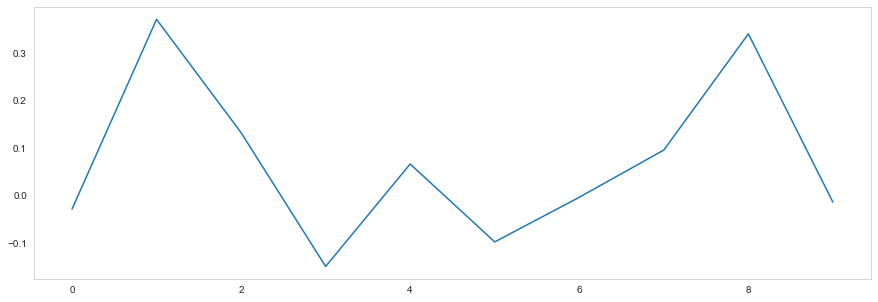

In [28]:
fig = plt.figure()
plt.plot(train_results_over_episodes)
plt.show()

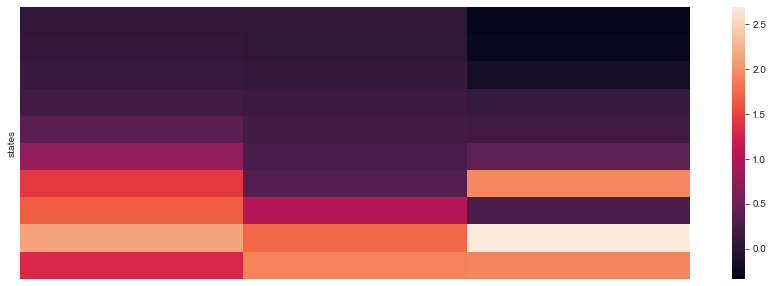

In [29]:
fig = plt.figure()
sns.heatmap(data=q, xticklabels=False, yticklabels=False)
plt.show()

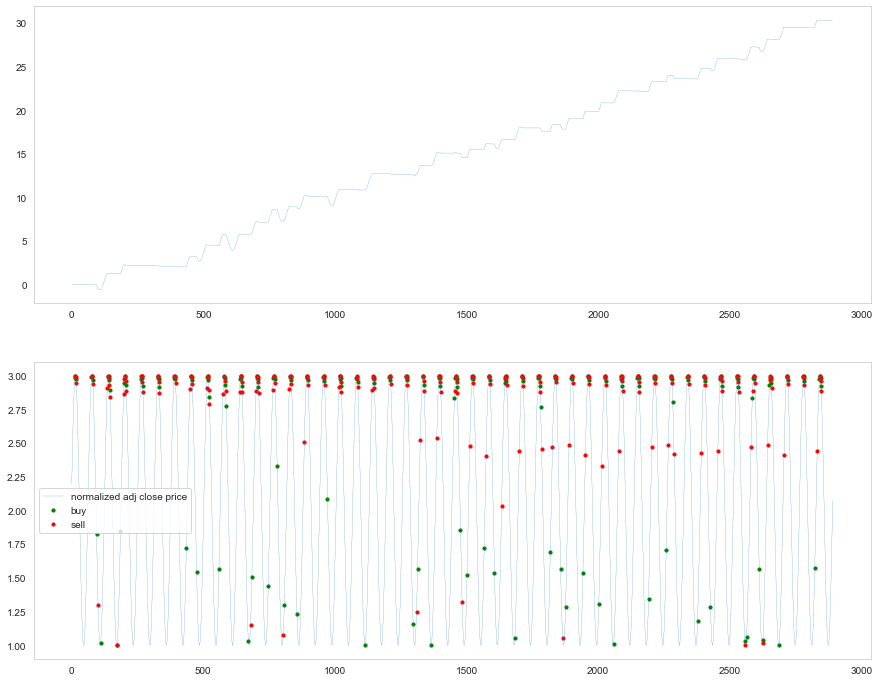

In [30]:
fig = visualize_results(train_actions_history, train_equity_curve)
plt.show()

In [31]:
test_data = test_df[['Normalized_Close', 'state']]
test_actions_history, test_returns_since_entry, test_equity_curve = eval_q_learning(test_data, q, max_units, state_lookback)

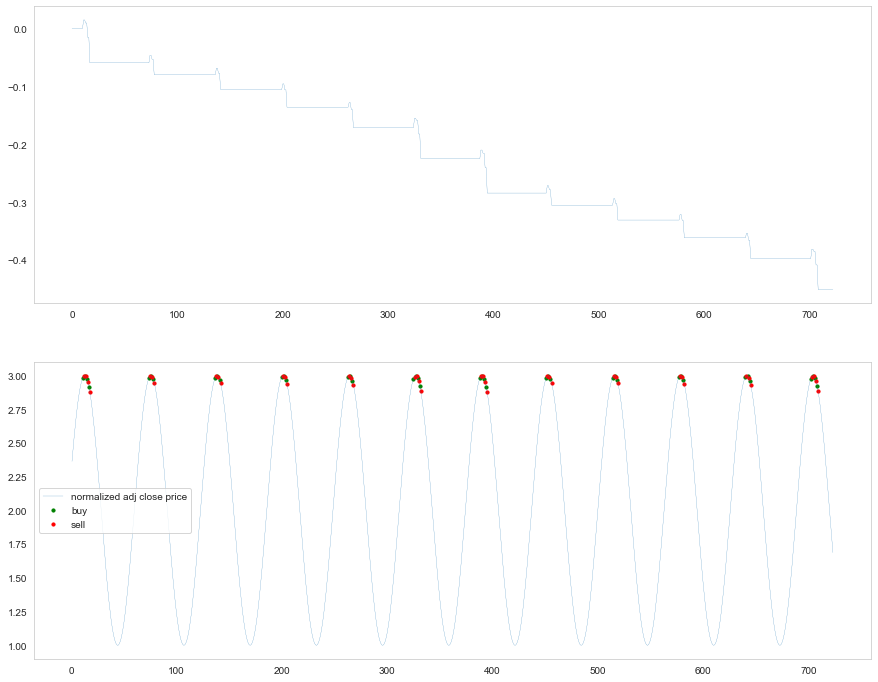

In [32]:
fig = visualize_results(test_actions_history, test_equity_curve)
plt.show()